In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(1234)

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# ブラウン運動の発生

In [3]:
def brownian_motion(n, T):
    """
    Simulates a Brownian motion
    :param int n : the number of discrete steps
    :param int T: the number of continuous time steps
    :param float h: the variance of the increments
    """
    delta_t = 1. * T/n  # decide the increment of the time
    partition = [i * delta_t for i in range(n + 1)] # make a partition
    
    # ブラウン運動の差分（平均：０，標準偏差：時間の差分）
    random_increments = np.random.normal(loc = 0.0, scale = np.sqrt(delta_t), size = n)
    '''
    where loc = "mean(average)", scale = "variance", n = the number of increments.
    (正規分布を発生させている)
    '''
    # making data like a Brownian motion
    brownian_motion = np.cumsum(random_increments)  # calculate the brownian motion
    # insert the initial condition
    brownian_motion = np.insert(brownian_motion, 0, 0.0)
    
    return brownian_motion, random_increments, partition


# SABR_2モデル（模擬データの作成）

In [4]:
def SABR_vol(dB_1, dB_2, n, delta_t, a, rho, vol_0):
    vols_root = [vol_0]
    for i in range(1, n + 1):
        pre_vol = vols_root[i-1]
        vol_root = pre_vol * math.exp((1/2) * a * (rho * dB_1[i-1] + np.sqrt(1 - rho**2) * dB_2[i-1]) - (1/4) * (a**2) * delta_t)
        vols_root.append(vol_root)
    return vols_root

def simulate_SABR_2(n = 100, T = 1, alpha = 0.3, beta = 1, rho = 0.5, X_0 = 0.1, vol_0 = 0.1, fig_mode = False):
    '''
    出力：
        データテーブル（columns : timestamp, process, volatility**(1/2))
    '''
    
    
    
    # BMの生成
    BM_1, dB_1, partition = brownian_motion(n, T)
    BM_2, dB_2, partition = brownian_motion(n, T)
    dt = 1. * T / n
    
    partition = [dt * i for i in range(n + 1)]
    
    # SABR model に従う ”Process X”と ”volatility sig” を作成
    X = np.zeros(n + 1)
    X[0] = X_0
    
    SABR_vols = SABR_vol(dB_1 = dB_1, dB_2 = dB_2, n = n, delta_t = dt, a = alpha, rho = rho, vol_0 = vol_0)
    
    for i, dB_1_t, dB_2_t, t in zip(range(1, n+1), dB_1, dB_2, partition):
        # 1つ前の X と sig の値
        pre_vol = SABR_vols[i-1]
        pre_X = X[i-1] 
        # X と sig の値を計算（SDEに従う）
        X[i] = pre_X + pre_vol * pre_X**(beta) * dB_1_t
        
    #print('vol size : {}, X size : {}, partition size : {}'.format(len(SABR_vols), X.size, len(partition)))
    
    data_array = np.array([partition, X, SABR_vols]).T
    df = pd.DataFrame(data_array, columns = ['timestamp', 'process', 'volatility'])
    
    if fig_mode:
        fig, ax = plt.subplots()

        # plot the process X and volatility sigma
        ax.plot(partition, X, color = 'blue', label = 'process')
        ax.plot(partition, SABR_vols, color = 'red', label = 'volatility')
        ax.set_xlabel('time(s)')
        ax.set_ylabel('process X and volatility sigma')

        # 以下はそんなに関係ないから気にしなくていい．
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().yaxis.set_ticks_position('left')
        plt.gca().xaxis.set_ticks_position('bottom')

        plt.legend();

    return df

# ハイパーパラメータの設定,ディレクレ核,乱数の発生

In [27]:
# ハイパーパラメータの設定
T = 1
n = 100

N = 141
e = 0.5
K = 500

alpha = 0.01

beta = 0
rho = -0.2

X_0 = 1000
vol_0 = 6

In [28]:
#乱数を発生させる
y = np.random.normal(loc = 0, scale = e , size = 10000)

In [29]:
y[0]

-0.5404192073901877

In [34]:
#ディレクレ核
def D(N,x):
    return 1/(2*N + 1) * (np.sin(2 * np.pi * (N + 1/2) * x)) / (np.sin(2 * np.pi * x / 2) ) 

# t全て

In [35]:
def cal_spotVol(n, N, y, T, alpha, beta, rho, X_0, vol_0):
    partition = [i/n for i in range(n)]
    df_path = simulate_SABR_2(n = n, T = T, alpha = alpha, beta = beta, rho = rho, X_0 = X_0, vol_0 = vol_0)
    X = df_path['process'].values
  
    vol_process = []
    #各時刻tに対して分割i,jに対するスポットボラティリティを計算する
    #nは分割数
    for t in partition:
        total_i = 0
        for i in range(K):
            add_j = 0
            for j in range(n):
                if (np.sin(2 * np.pi* (t - partition[j] + y[i]) /2)  == 0):
                    D_ = 1
                else:
                    D_ = D(N, t - partition[j] + y[i])
                
                add_j += D_ * (X[j+1] - X[j])
                
            total_i += add_j**2
    
        spot_vol = (2*N + 1) * total_i / K
        vol_process.append(spot_vol)

    #個数を合わせる為
    df_path = df_path[:-1]

    df_path['spot volatility'] = vol_process
    
    if beta != 0:
        df_path['abs_error_vol'] = np.abs((df_path['process'] * df_path['volatility'])**2 - df_path['spot volatility'])
    else:
        df_path['abs_error_vol'] = np.abs(df_path['volatility']**2 - df_path['spot volatility'])

    return df_path

#L2誤差を吐き出す関数を定義
def cal_error(df_path):
    error = np.linalg.norm(df_path['volatility']**2 - df_path['spot volatility'], ord=2) / np.sqrt(n)
    return error

In [36]:
df_path = cal_spotVol(n, N, y, T, alpha, beta, rho, X_0, vol_0)

In [37]:
df_path.head(15)

,timestamp,process,volatility,spot volatility,abs_error_vol
0,0.00,1000.000000,6.000000,35.285474,0.714526
1,0.01,999.074717,5.997158,39.650140,3.684234
2,0.02,999.584547,5.996855,31.996105,3.966167
3,0.03,999.992061,6.001522,38.978796,2.960533
4,0.04,999.596282,5.996340,36.422548,0.466449
5,0.05,999.403014,5.993812,39.891416,3.965638
6,0.06,999.005530,5.993292,34.285391,1.634162
7,0.07,997.898219,5.992473,36.798523,0.888792
8,0.08,997.469132,5.995370,41.727933,5.783469
9,0.09,997.752549,5.999468,36.635701,0.642090


In [ ]:
print("L2-error is",cal_error(df_path))

L2-error is 1.9954035006742017


## パラメーター固定した場合のL2誤差の平均と分散

In [ ]:
errors = []
for _ in range(30):
  df_path = cal_spotVol(n, N, y, T, alpha, beta, rho, X_0, vol_0)
  error = cal_error(df_path)
  print(error)
  print('----' * 10)
  errors.append(error)

errors = np.array(errors)
print(f'mean = {np.mean(errors)}', f'var = {np.var(errors)}')


KeyboardInterrupt: ignored

# 可視化

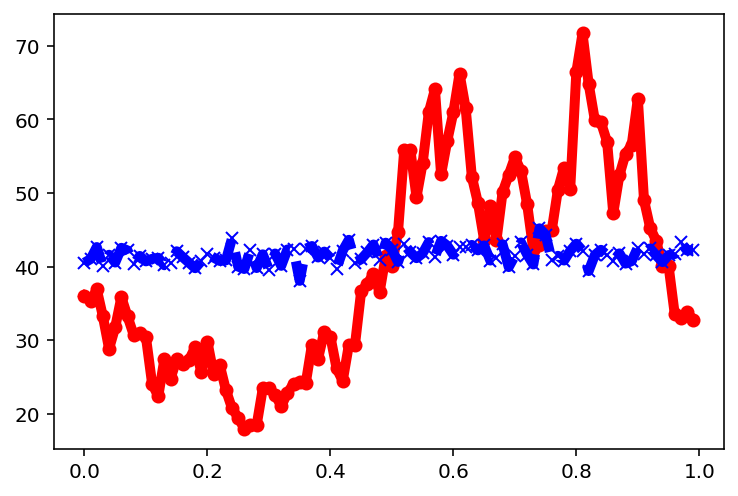

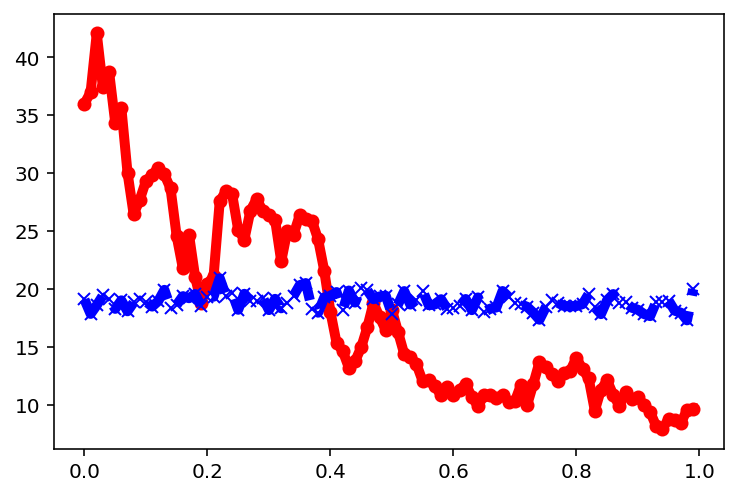

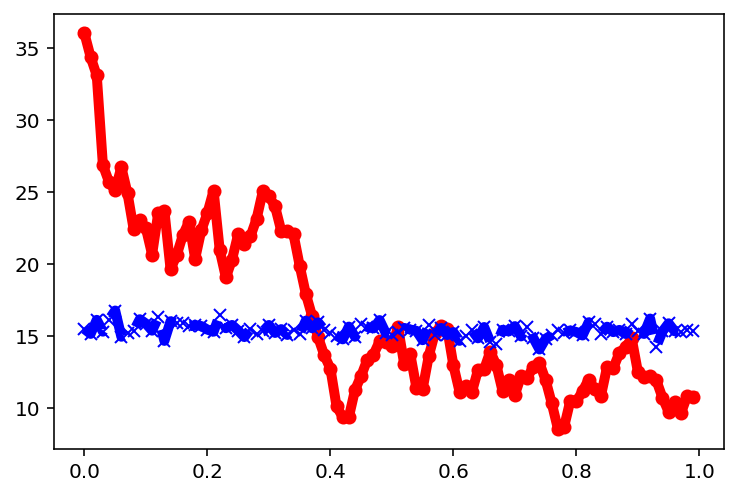

In [ ]:
for _ in range(3):
  df_path = cal_spotVol(n, N, y, T, alpha, beta, rho, X_0, vol_0)

  t = df_path['timestamp']
  X = (df_path['volatility'])**2
  V = df_path['spot volatility']

  fig, ax = plt.subplots()
  ax.plot(t, X, 'o-r', t, V, 'x--b', linewidth = 5)

  plt.show()